In [8]:
import numpy as np
import torchaudio
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

In [10]:
from encodec import EncodecModel   # `pip install encodec` if unavailable

model = EncodecModel.encodec_model_48khz()  # will download and cache the weights when run for the first time

In [11]:
stft_transformer = torchaudio.transforms.Spectrogram(n_fft=1<<13, power=2)
def compute_fp_stft(p):
    stft = stft_transformer(torch.Tensor(p)).numpy()
    stft = 10 * np.log10( np.clip( stft, 1e-10, 1e6 ) )
    fingerprint = np.mean( stft, axis=(2) ) 
    return fingerprint

In [12]:
audio_path = Path("../data/ai/suno1.m4a")
audio_path.exists()

audio, sr = torchaudio.load(audio_path, channels_first = False)
audio = torch.Tensor(audio.T).unsqueeze(0)
frames = model.encode(audio)

fft_audio_input = compute_fp_stft(audio[0])

# we ignore the output scaling and linear interpolation between frames (1 sec audio) and directly decode everything
codes = torch.concatenate([a[0] for a in frames], -1)
with torch.no_grad():
    emb = model.quantizer.decode(codes.transpose(0, 1))
    post_lstm = model.decoder.model[:2](emb)

audio_latent = post_lstm

In [13]:
audio_latent.shape

torch.Size([1, 512, 30286])

In [14]:
input_fft = compute_fp_stft(audio_latent[0])
mean_input_fft = np.mean(input_fft, 0)

ffts = []
with torch.no_grad():
    for l in [4, 7, 10, 13]: # layers of deconvs
        latent = model.decoder.model[2:l](audio_latent)
        fft_latent = compute_fp_stft(latent[0])
        ffts.append(fft_latent)

with torch.no_grad():
    audio_rec = model.decoder.model[2:](audio_latent)
output_fft = compute_fp_stft(audio_rec[0])

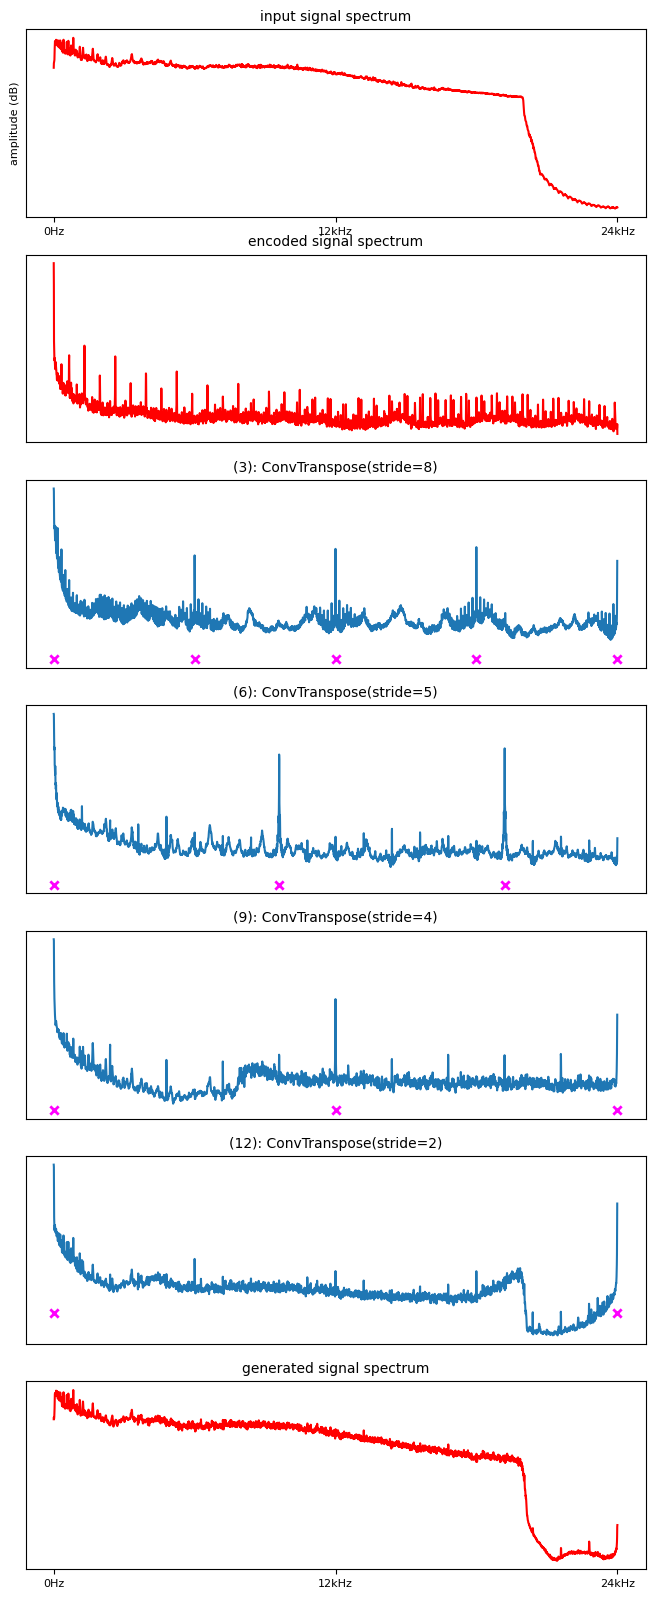

In [15]:
def plot_fractal(k=8, N=4097, y_offset=0):
    """ Display where the peaks are supposed to be. """
    x = []
    y = []
    for t in range(0, k//2+1):
        x.append(t*2*N/k)
        y.append(y_offset)
    plt.scatter(x, y, c="magenta", marker="x", linewidth=2, clip_on=False)

plt.figure(figsize=(8, 20))
plt.subplot(7, 1, 1)
plt.plot(np.mean(fft_audio_input, 0), color="red")
plt.title("input signal spectrum", fontsize=10)
plt.xticks([0, 2048, 4096], ["0Hz", "12kHz", "24kHz"], fontsize=8)
plt.yticks([], [])
plt.ylabel("amplitude (dB)", fontsize=8)

plt.subplot(7, 1, 2)
plt.plot(np.mean(input_fft, 0), color="red")
plt.title("encoded signal spectrum", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])

plt.subplot(7, 1, 3)
plt.plot(np.mean(ffts[0], 0))
plt.title("(3): ConvTranspose(stride=8)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=8, y_offset=np.mean(ffts[0])-8)

plt.subplot(7, 1, 4)
plt.plot(np.mean(ffts[1], 0))
plt.title("(6): ConvTranspose(stride=5)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=5, y_offset=np.mean(ffts[1])-8)

plt.subplot(7, 1, 5)
plt.plot(np.mean(ffts[2], 0))
plt.title("(9): ConvTranspose(stride=4)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=4, y_offset=np.mean(ffts[2])-8)

plt.subplot(7, 1, 6)
plt.plot(np.mean(ffts[3], 0))
plt.title("(12): ConvTranspose(stride=2)", fontsize=10)
plt.xticks([], [])  # the x-axis doesn't really make sense here
plt.yticks([], [])
plot_fractal(k=2, y_offset=np.mean(ffts[3])-8)

plt.subplot(7, 1, 7)
plt.plot(np.mean(output_fft, 0), label="output", color="red")
plt.title("generated signal spectrum", fontsize=10)

plt.xticks(fontsize=10)
plt.yticks([], [])
plt.xticks([0, 2048, 4096], ["0Hz", "12kHz", "24kHz"], fontsize=8)
plt.show()